In [76]:
import pickle
import calendar
import os
import numpy as np
import pandas as pd
import statsmodels.api as sm
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import datetime
from regressors import stats as s
from dateutil import parser
from itertools import compress

from sklearn.linear_model import LinearRegression, RidgeCV, Ridge
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.utils import shuffle

from xgboost import XGBRegressor, DMatrix

import warnings

warnings.filterwarnings("ignore")

sns.set(rc={"figure.figsize": (11.7, 8.27)})

In [77]:
dat = pd.read_csv("../cleaned_data.csv")
dat = dat.loc[:, "Access":]
dat["Date Aired"] = pd.to_datetime(dat["Date Aired"], format="%Y-%m-%d")
dat["Time Aired"] = pd.to_datetime(dat["Time Aired"], format="%H:%M:%S").dt.time

In [78]:
outliers = pd.read_pickle('outlier_stations.pickle')

outlier_stations = list(outliers.index.get_level_values('Station ID'))[0:12]
outlier_stations

dat = pd.concat([dat, pd.get_dummies(dat["Estimate"])], axis=1)
dat = pd.concat([dat, pd.get_dummies(dat["Access"])], axis=1)
dat = pd.concat([dat, pd.get_dummies(dat["Market"])], axis=1)
dat = pd.concat([dat, pd.get_dummies(dat["DOW"])], axis=1)
dat = pd.concat([dat, pd.get_dummies(dat["daypart"])], axis=1)

dat['is_outlier'] = np.where(np.isin(dat['Station ID'], outlier_stations), 1, 0)
dat.columns

Index(['Access', 'DMA', 'Date Aired', 'Estimate', 'GRP', 'Impressions',
       'Length', 'Market', 'Media', 'Spot Cost', 'Spot Type', 'Station ID',
       'Time Aired', 'DOW', 'daypart', 'Q119', 'Q219', 'Q319', 'Q419', '15DC',
       '15GD', '15PN', '30BP', '30DE', '30DP', '30GD', '30GX', '30PL', '30PM',
       '30PT', '30SR', '30TN', '30VE', 'SV15',
       'Cable                         ', 'DirecTV                       ',
       'Dish Network                  ', 'National Network              ',
       'Over-the-top content          ', 'Friday', 'Monday', 'Saturday',
       'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'Daytime', 'Early Fringe',
       'Late Fringe', 'Late Night', 'Morning', 'Overnight', 'Primetime',
       'is_outlier'],
      dtype='object')

In [79]:
dat = dat.rename(columns=lambda x: x.strip().replace(' ', '_'))
dat.columns

Index(['Access', 'DMA', 'Date_Aired', 'Estimate', 'GRP', 'Impressions',
       'Length', 'Market', 'Media', 'Spot_Cost', 'Spot_Type', 'Station_ID',
       'Time_Aired', 'DOW', 'daypart', 'Q119', 'Q219', 'Q319', 'Q419', '15DC',
       '15GD', '15PN', '30BP', '30DE', '30DP', '30GD', '30GX', '30PL', '30PM',
       '30PT', '30SR', '30TN', '30VE', 'SV15', 'Cable', 'DirecTV',
       'Dish_Network', 'National_Network', 'Over-the-top_content', 'Friday',
       'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday',
       'Daytime', 'Early_Fringe', 'Late_Fringe', 'Late_Night', 'Morning',
       'Overnight', 'Primetime', 'is_outlier'],
      dtype='object')

In [80]:
unseen = dat[(dat.Impressions.eq(0.0)) & (dat.GRP.eq(0.0))]
training = dat[dat.Impressions > 0.0]

labels = [
        "Length",
        "Spot_Cost",
        "Q119",
        "Q219",
        "Q319",
        "Q419",
        "15GD",
        "15PN",
        "30BP",
        "30DE",
        "30DP",
        "30GD",
        "30GX",
        "30PL",
        "30PM",
        "30PT",
        "30SR",
        "30TN",
        "30VE",
        "SV15",
        "Cable", 
        "DirecTV",
        "Dish_Network",
        "National_Network",
        "Over-the-top_content",
        "Monday",
        "Sunday",
        "Thursday",
        "Tuesday",
        "Wednesday",
        "Daytime", 
        "Early_Fringe",
        "Late_Fringe",
        "Late_Night",
        "Morning",
        "Overnight",
        "Primetime",
        "is_outlier"
    ]

X = training.loc[:,labels]
y = training.loc[:, "Impressions"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

## Ridge CV Tuning

In [81]:
rcv = RidgeCV(alphas=[1e-3, 1e-4, 1e-1, 1, 10], normalize=True)
rcv.fit(X_train, y_train)
rcv.score(X_train, y_train)

0.4428296158643146

In [82]:
rcv.get_params()

{'alphas': array([1.e-03, 1.e-04, 1.e-01, 1.e+00, 1.e+01]),
 'cv': None,
 'fit_intercept': True,
 'gcv_mode': None,
 'normalize': True,
 'scoring': None,
 'store_cv_values': False}

In [83]:
preds_rcv = rcv.predict(X_test)

## Ridge regression with SelectFromModel

In [84]:
mse_list = []
score_list = []
a_list = []
for a in [1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10]:
    ridge = Ridge(alpha=a, normalize=True, solver='sag', random_state=1234)
    
    ridge.fit(X_train, y_train)
    preds = ridge.predict(X_test)
    score_list.append(ridge.score(X_test, y_test))
    mse_list.append(MSE(y_test, preds))
    a_list.append(a)

In [85]:
ridge_results = pd.DataFrame(list(zip(a_list, score_list, mse_list)), 
                             columns = ['Alpha', 'R2', 'MSE'])

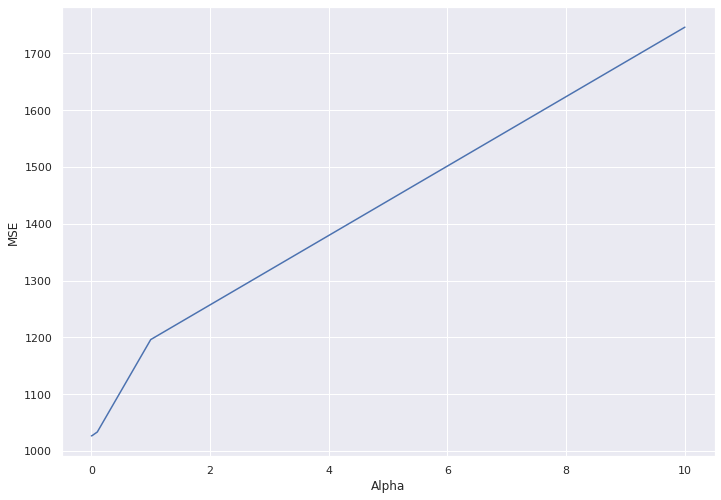

In [86]:
line = sns.lineplot('Alpha', 'MSE', data=ridge_results)
plt.show()

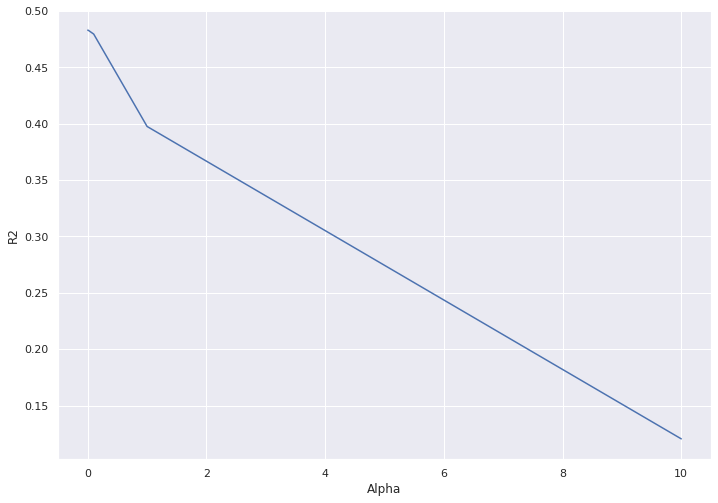

In [87]:
line = sns.lineplot('Alpha', 'R2', data=ridge_results)
plt.show()

In [100]:
rcv_list = [rcv.alpha_, rcv.score(X_test, y_test), MSE(y_test, rcv.predict(X_test))]
rcv_results = pd.DataFrame(rcv_list).transpose()
rcv_results

,0,1,2
0,0.001,0.482991,1026.473897


In [101]:
ridge_results[ridge_results.MSE == ridge_results.MSE.min()]

,Alpha,R2,MSE
0,1.000000e-10,0.482993,1026.469595


In [102]:
selector_ridge = SelectFromModel(estimator=Ridge(alpha=1.000000e-10, normalize=True)).fit(X_train, y_train)
selector_ridge.get_support()

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False,  True,  True,  True, False, False, False,
       False, False, False, False, False, False,  True,  True,  True,
       False,  True])

In [104]:
selected_labels = list(compress(labels, list(selector_ridge.get_support())))
selected_labels

X_adj = training.loc[:,selected_labels]
X_train_adj, X_test_adj, y_train_adj, y_test_adj = train_test_split(X_adj, y, test_size=0.25)

#### Ridge Regression with selected predictors

In [106]:
ridge_adjusted = Ridge(alpha=1.000000e-10, normalize=True)
ridge_adjusted.fit(X_train_adj, y_train_adj)
preds = ridge_adjusted.predict(X_test_adj)

print(ridge_adjusted.score(X_test_adj, y_test_adj))
print(MSE(y_test, preds))

0.2840171352312678
2570.9133423147505
